In [89]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# --- Configuration ---
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Display all columns when printing dataframes
pd.set_option('display.max_columns', None)

# Set plot style
sns.set(style="whitegrid")

# Set global random state for reproducibility
RANDOM_STATE = 42

# --- Data Loading & Initial Cleaning ---
try:
    df = pd.read_csv('creditcard.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the file is in the working directory.")

# Check for and remove duplicate transactions to prevent data leakage
initial_shape = df.shape
df.drop_duplicates(inplace=True)
final_shape = df.shape

print(f"Original dataset shape: {initial_shape}")
print(f"Shape after removing duplicates: {final_shape}")

Data loaded successfully.
Original dataset shape: (284807, 31)
Shape after removing duplicates: (283726, 31)


Generating feature distribution plots (KDE)...


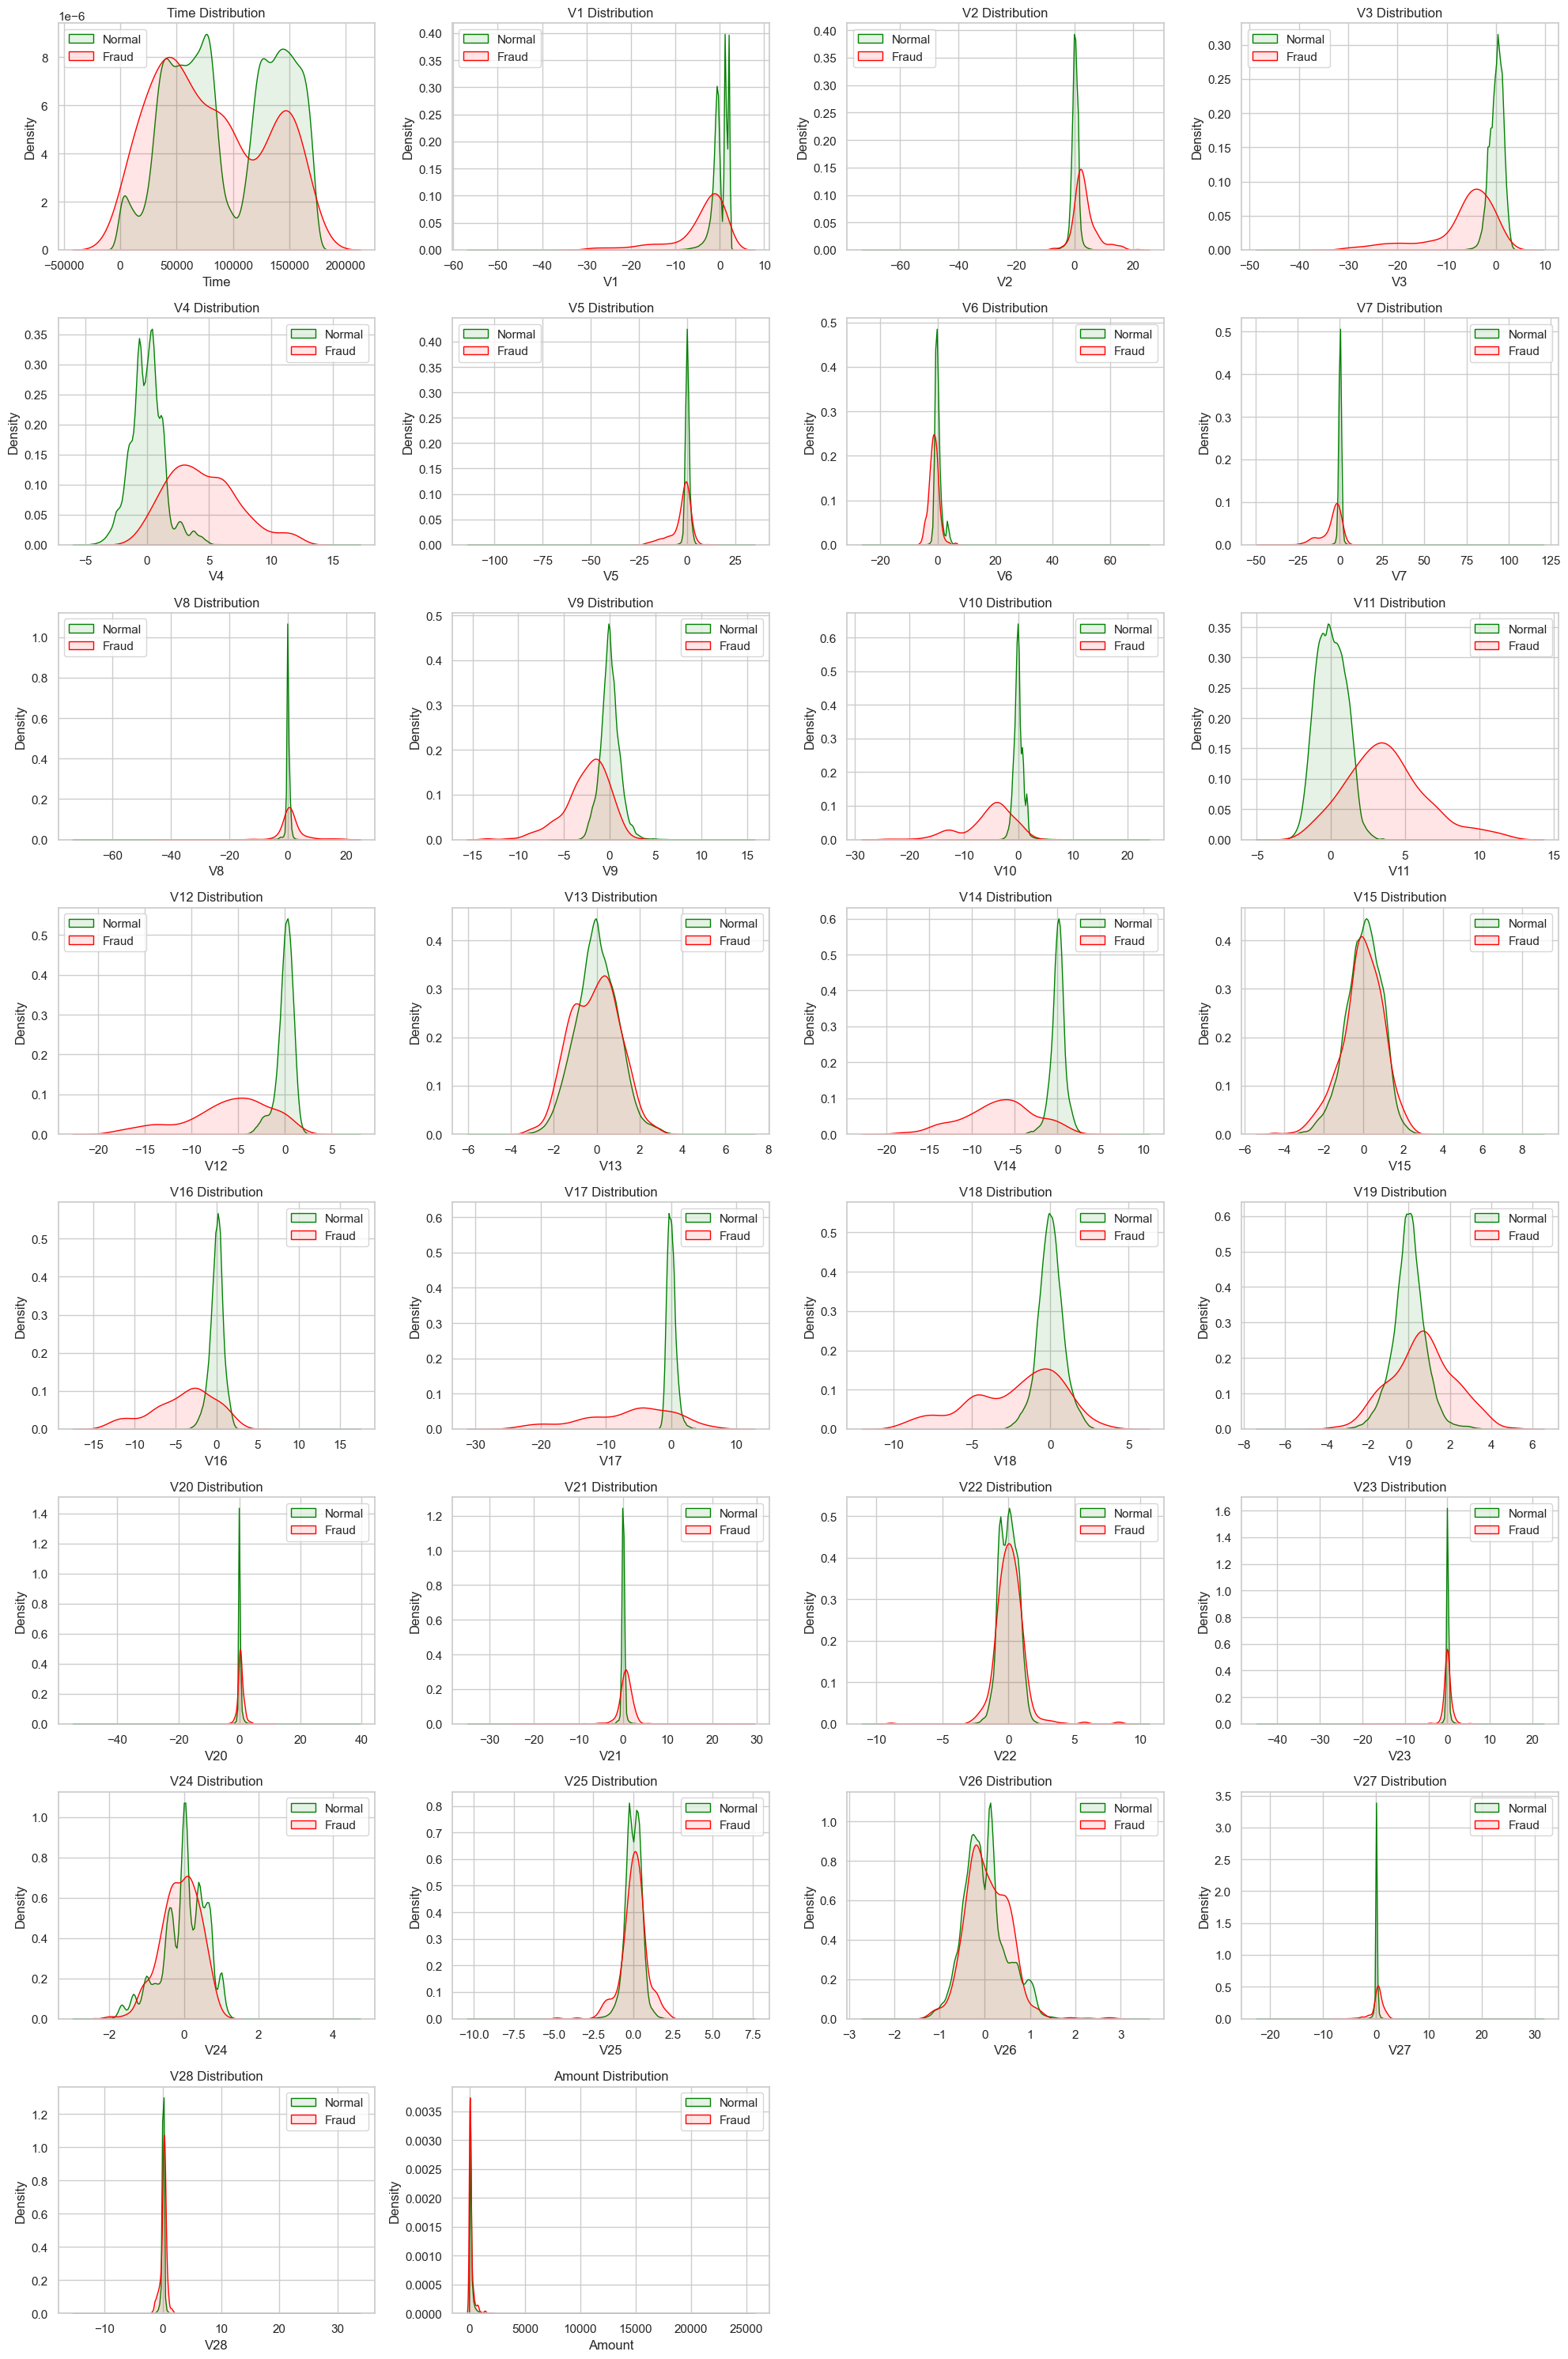

In [90]:
print("Generating feature distribution plots (KDE)...")

# Identify feature columns (excluding the target 'Class')
features = df.columns.drop('Class')

# Initialize the subplot grid (8 rows x 4 columns)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 30))
axes = axes.flatten()

# Iterate through each feature to plot its distribution
for i, col in enumerate(features):
    ax = axes[i]
    
    # Plot distribution for Non-Fraudulent transactions (Class 0)
    sns.kdeplot(
        df[df['Class'] == 0][col], 
        ax=ax, 
        label='Normal', 
        color='green', 
        fill=True, 
        alpha=0.1
    )
    
    # Plot distribution for Fraudulent transactions (Class 1)
    sns.kdeplot(
        df[df['Class'] == 1][col], 
        ax=ax, 
        label='Fraud', 
        color='red', 
        fill=True, 
        alpha=0.1
    )
    
    ax.set_title(f'{col} Distribution')
    ax.legend()

# Remove unused subplots to maintain a clean layout
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

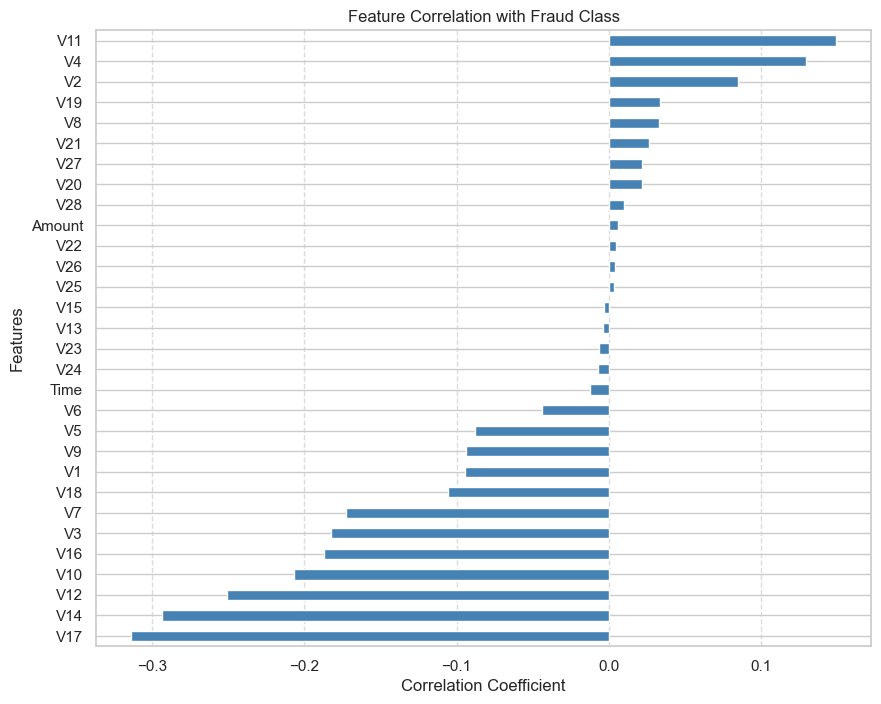

--- EDA Summary ---
1. Top Negative Correlations: V14, V12, V10 (Inverse relationship with fraud).
2. Top Positive Correlations: V11, V4 (Direct relationship with fraud).
3. Negligible Correlations: V13, V15, V22, V25, V26.
4. Scaling Requirement: 'Time' and 'Amount' differ significantly in scale from V-features and require RobustScaler.


In [93]:
# Calculate correlations between features and the target variable
correlations = df.corrwith(df['Class']).drop('Class').sort_values()

# Plot correlation coefficients
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Fraud Class')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Summary of findings
print("--- EDA Summary ---")
print("1. Top Negative Correlations: V14, V12, V10 (Inverse relationship with fraud).")
print("2. Top Positive Correlations: V11, V4 (Direct relationship with fraud).")
print("3. Negligible Correlations: V13, V15, V22, V25, V26.")
print("4. Scaling Requirement: 'Time' and 'Amount' differ significantly in scale from V-features and require RobustScaler.")

In [94]:
# --- Data Preprocessing & Splitting ---

# 1. Feature Scaling
# Apply RobustScaler to 'Amount' and 'Time' to handle outliers effectively
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Remove original columns and re-insert scaled versions at the beginning
df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', df.pop('scaled_amount'))
df.insert(1, 'scaled_time', df.pop('scaled_time'))

# 2. Define Features (X) and Target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# 3. Train-Test Split
# Reserve 20% of the data for final evaluation (Hold-out set)
# Stratify ensures the fraud ratio remains consistent in both sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# --- Stratified Cross-Validation with SMOTE Pipeline ---

print("Starting Stratified Cross-Validation (5 Folds)...")

# Initialize Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Define the Pipeline
# Crucial: SMOTE is applied ONLY to the training fold within the loop to prevent data leakage.
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

auprc_scores = []

# Iterate through each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_val, y_train_val), 1):
    # Split data for the current fold
    # Using .iloc for positional indexing on pandas DataFrames
    X_fold_train, X_fold_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    # Train the pipeline (SMOTE -> XGBoost)
    pipeline.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities on the validation fold
    y_prob = pipeline.predict_proba(X_fold_val)[:, 1]
    
    # Calculate AUPRC (Area Under Precision-Recall Curve)
    precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
    score = auc(recall, precision)
    auprc_scores.append(score)
    
    print(f"Fold {fold}: AUPRC = {score:.4f}")

# Output summary statistics
mean_score = np.mean(auprc_scores)
std_score = np.std(auprc_scores)

print(f"\nCross-Validation Results:")
print(f"Mean AUPRC: {mean_score:.4f} (Std Dev: {std_score:.4f})")

Starting Stratified Cross-Validation (5 Folds)...


[00:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Fold 1: AUPRC = 0.8237


[00:54:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Fold 2: AUPRC = 0.8207


[00:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Fold 3: AUPRC = 0.7365


[00:54:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Fold 4: AUPRC = 0.7982


[00:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Fold 5: AUPRC = 0.8292

Cross-Validation Results:
Mean AUPRC: 0.8016 (Std Dev: 0.0343)


Training final model on the complete training dataset...


[00:55:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Final Test AUPRC: 0.7896
Optimal Threshold (Max F1-Score): 0.9519

--- Classification Report (Optimized Threshold) ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
       Fraud       0.85      0.77      0.81        95

    accuracy                           1.00     56746
   macro avg       0.92      0.88      0.90     56746
weighted avg       1.00      1.00      1.00     56746



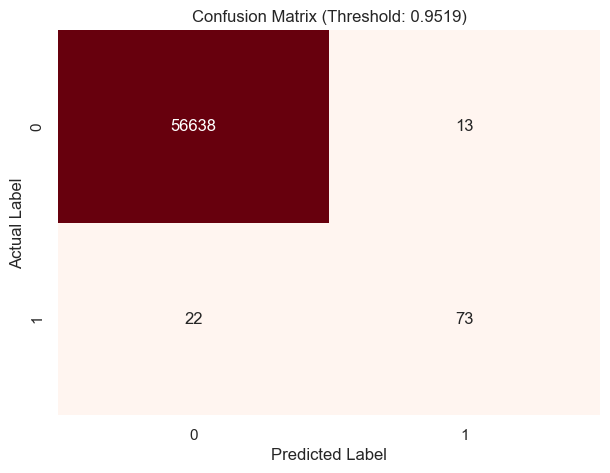

In [95]:
print("Training final model on the complete training dataset...")

# Train the pipeline (SMOTE + XGBoost) on the full training set (X_train_val)
# This utilizes all available training data before the final test
pipeline.fit(X_train_val, y_train_val)

# Generate probabilities for the hold-out test set
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# Calculate Precision-Recall curve components
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
auprc_test = auc(recall, precision)

# --- Threshold Tuning ---
# Maximize F1-Score to find the optimal balance between Precision and Recall
# Note: The 'thresholds' array is 1 element shorter than precision/recall arrays
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
best_thresh = thresholds[ix]

print(f"Final Test AUPRC: {auprc_test:.4f}")
print(f"Optimal Threshold (Max F1-Score): {best_thresh:.4f}")

# Apply the optimal threshold to generate binary predictions
y_pred_tuned = (y_prob_test >= best_thresh).astype(int)

# --- Evaluation ---
print("\n--- Classification Report (Optimized Threshold) ---")
print(classification_report(y_test, y_pred_tuned, target_names=['Normal', 'Fraud']))

# Confusion Matrix Visualization
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix (Threshold: {best_thresh:.4f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Generating SHAP feature importance analysis...


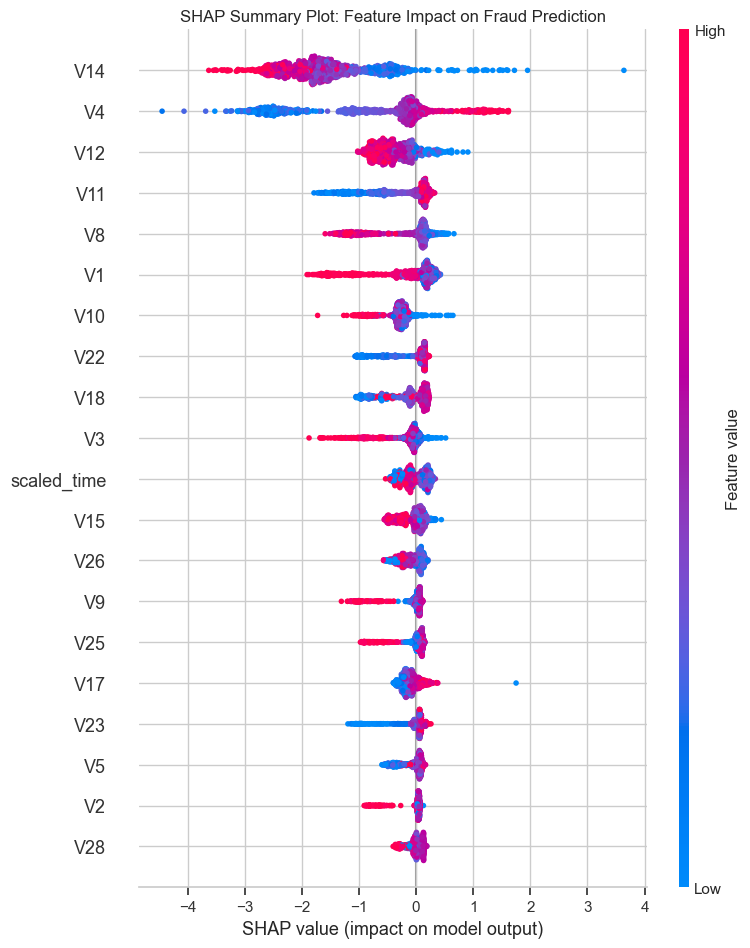

In [97]:
print("Generating SHAP feature importance analysis...")

# 1. Extract the trained model
# We need to access the specific XGBoost step from the pipeline
final_model = pipeline.named_steps['xgb']

# 2. Initialize SHAP Explainer
# TreeExplainer is optimized for tree-based models
explainer = shap.TreeExplainer(final_model)

# 3. Calculate SHAP Values
# We use a random sample of 1000 instances from the test set for computational efficiency.
# Note: The input data must be in the same format as the model input (scaled, but not oversampled).
X_test_sample = X_test.sample(1000, random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_test_sample)

# 4. Visualization (Summary Plot)
# This plot shows both feature importance (y-axis order) and the impact of feature values (color)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Summary Plot: Feature Impact on Fraud Prediction')
plt.show()

In [98]:
import joblib

print("Saving model artifacts for deployment...")

# 1. Extract the trained classifier from the pipeline
# We extract the 'xgb' step because SMOTE is only used during training.
# For inference (prediction), we only need the trained model.
final_model = pipeline.named_steps['xgb']

# 2. Serialize (save) the model to disk
joblib.dump(final_model, 'fraud_model.pkl')

# 3. Serialize the scaler
# This is required to preprocess new input data (Amount/Time) 
# using the exact same median and quartiles as the training data.
joblib.dump(rob_scaler, 'scaler.pkl')

print("Success: 'fraud_model.pkl' and 'scaler.pkl' have been saved.")

Saving model artifacts for deployment...
Success: 'fraud_model.pkl' and 'scaler.pkl' have been saved.
